## 0. 数据准备

In [68]:
import os
import sys
sys.path.append('/root/Workspace/project/krrnv3')
from dataset.linemod.batchdataset import PoseDataset
from lib.network.krrn import KRRN
from lib.network.loss import KRRNLoss
from lib.utils.metric import Metric
from lib.utils.utlis import batch_intrinsic_transform
from lib.utils.utlis import load_part_module
from lib.transform.trans import estimateSimilarityTransform
from tools.trainer import Trainer
from lib.transform.coordinate import crop_resize_by_warp_affine
from pykeops.torch import generic_argkmin

In [65]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import kornia as kn
from mmcv import Config
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
from pathlib import Path

In [3]:
PROJETCT_PATH = Path(os.path.realpath(os.getcwd())).parent.parent
cfg = Config.fromfile(f'{PROJETCT_PATH}/config/linemod/lm_v3.py')
%matplotlib notebook

In [4]:
dataset_root = '/root/Source/ymy_dataset/Linemod_preprocessed'
num_points = 500
num_cls = 1
num_kp = 8
cls_type = 'cam'

dataset_test = PoseDataset('test', cfg.Data.NUM_POINTS, True, dataset_root, 0.0, 8, cls_type=cls_type, cfg=cfg)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=0)
sym_list = dataset_test.sym_obj
metric = Metric(sym_list)
tst_ds_iter = dataloader_test.__iter__()
diameters = dataset_test.diameter
diameter = diameters[0]

test Use Object:  [4]
processing item :  4
len of real test:  1020
len of synthetic test:  0
len of all test:  1020 



## 1. 模型初始化

In [70]:
estimator = KRRN(num_cls=cfg.Module.NUM_CLS, cfg=cfg)
estimator.cuda()
estimator.eval()
cpkt = '/root/Source/ymy_dataset/trained/krrnv3/linemod/12/pose_model_1_0.010363257411803465_pose.pth'
estimator = load_part_module(estimator, cpkt)
trainer = Trainer(estimator, None, None, None, cfg=cfg)
knn = generic_argkmin('SqDist(x, y)', 'a = Vi(1)', 'x = Vi(3)', 'y = Vj(3)')
criterion = KRRNLoss(sym_list=sym_list, knn=knn, cfg=cfg)

# 2. 查看数据

## 2.1 前向过程

In [75]:
datas = tst_ds_iter.__next__()
with torch.no_grad():
    opt_pose = True
    pred = estimator(
        datas['img_croped'].cuda(),
        datas['cloud'].cuda(),
        datas['choose'].cuda(),
        datas['region_point'].cuda(),
        True
    )
    gt = {
        'xyz': datas['xyz'].cuda(),
        'normal': datas['normal'].cuda(),
        'region': datas['region'].cuda(),
        'mask': datas['mask'].cuda(),
        'target': datas['target'].cuda(),
        'model_points': datas['model_points'].cuda(),
        'cls_id': datas['cls_id'].cuda(),
        'target_r': datas['target_r'].cuda(),
        'region_point': datas['region_point'].cuda()
    }
    loss_dict = criterion(pred, gt, opt_pose=opt_pose)

In [103]:
ori_img = datas['ori_img'][0].cpu()
fx, fy, cx, cy = datas['intrinsic'][0].cpu().numpy()
rmin, rmax, cmin, cmax = datas['bbox'][0].cpu().numpy().astype(np.int16)

region = pred['region'].cpu()
xyz_off = pred['xyz'].cpu()


region = torch.softmax(region, 1)
region_cls_idx = region.argmax(dim=1, keepdim=True)  # [bs, 1, h, w]
bs, c, h, w = xyz_off.size()
n = region.size(1)
region_point = datas['region_point'].cpu()  # [bs, n, 3]
coordinate_choose_gt = datas['coordinate_choosed'][0].cpu()
xyz_gt = datas['xyz'][0].cpu()
# [bs, 1, 3, h, w]
xyz_base = torch.gather(region_point.view(bs, n, 3, 1, 1).repeat(1, 1, 1, h, w), 1,
                        region_cls_idx.unsqueeze(2).repeat(1, 1, 3, 1, 1))

base = (region.unsqueeze(2) * region_point.view(bs, n, 3, 1, 1)).mean(dim=1)

# xyz = xyz_off + xyz_base.squeeze(1)
xyz = xyz_off + base.squeeze(1)
# xyz = xyz_off

bs = xyz.size(0)
roi_extents = datas['extent']
left_border = datas['lfborder']
_choose = datas['choose']

num_points = 256
choose_idx = torch.randperm(_choose.size(-1), device=_choose.device)[:num_points]
choose = _choose[..., choose_idx]  # [bs, 1, 500]

x_map_choosed = datas['x_map_choosed'][:, choose_idx]
y_map_choosed = datas['y_map_choosed'][:, choose_idx]
_intrinsic = datas['intrinsic']
pts2d_res = torch.cat([x_map_choosed, y_map_choosed], -1)
K_matrix = batch_intrinsic_transform(_intrinsic)
coordintae = torch.cat([
    xyz[:, 0:1, :, :] * roi_extents[:, 0:1].view(-1, 1, 1, 1) + left_border[:, 0:1].view(-1, 1, 1, 1),
    xyz[:, 1:2, :, :] * roi_extents[:, 1:2].view(-1, 1, 1, 1) + left_border[:, 1:2].view(-1, 1, 1, 1),
    xyz[:, 2:3, :, :] * roi_extents[:, 2:3].view(-1, 1, 1, 1) + left_border[:, 2:3].view(-1, 1, 1, 1)
], dim=1).permute(0, 2, 3, 1)

coordinate_choosed_rt = torch.gather(coordintae.view(bs, -1, 3), -2, choose.permute(0, 2, 1).repeat(1, 1, 3))
coordinate_choosed = torch.gather(coordintae.view(bs, -1, 3), -2, _choose.permute(0, 2, 1).repeat(1, 1, 3))[0]
_, rvec, T, inliners = cv2.solvePnPRansac(
    objectPoints=coordinate_choosed_rt[0].numpy(), imagePoints=pts2d_res[0].numpy(),
    cameraMatrix=K_matrix[0].numpy(),
    distCoeffs=None, flags=cv2.SOLVEPNP_EPNP, confidence=0.9999, reprojectionError=1
)
angle_axis = torch.tensor(rvec, dtype=torch.float).view(bs, 3)
T = torch.tensor(T, dtype=torch.float).view(bs, 3)
P_out = torch.cat((angle_axis, T), dim=-1)

out_rx = kn.geometry.conversions.angle_axis_to_rotation_matrix(
    P_out[:, 0:3].contiguous().view(bs, 3)
)
out_tx = P_out[:, 3:6]
xyz_r = out_rx
xyz_t = out_tx

# mask
mask_gt = datas['mask'][0].cpu().clone()
mask = pred['mask'][0].cpu().clone()

# region
region_pred = (pred['region'].detach().cpu()*datas['mask']).clone()[0]
region_gt = (datas['region'].detach().cpu()*datas['mask'].squeeze(1).long()).clone()[0]
points = datas['cloud'][0].cpu().clone()

target = datas['target'][0]
target_r = datas['target_r']
target_t = datas['target_t']
model_points = datas['model_points']
pred_xyz_point = model_points @ xyz_r.permute(0, 2, 1) + xyz_t
dis_xyz_add, _ = metric.cal_adds_cuda(pred_xyz_point[0].cpu(), target.cpu(), 0)
dis_xyz_r = metric.angular_distance(xyz_r, target_r)
dis_xyz_t = metric.translation_distance(xyz_t, target_t)


masked_xyz = (xyz[0] * datas['mask'][0]).permute(1, 2, 0).cpu().clone()
masked_xyz_gt = xyz_gt.permute(1, 2, 0).cpu().clone()
masked_xyz_res = torch.abs(masked_xyz_gt-masked_xyz)

print(dis_xyz_r.item())
print(dis_xyz_t.item())
print(masked_xyz_res.mean().item())
print(loss_dict['loss_xyz'].item())

if dis_xyz_add < 0.1 * diameter:
    print(f'Success, dis_base_add: {dis_xyz_add:.04f}')
else:
    print(f'Failed, dis_base_add: {dis_xyz_add:.04f}')

0.7230721712112427
0.005918953567743301
0.0034934040158987045
0.02289742147911388
Success, dis_base_add: 0.0061


### 1.1 查看重建的normalized的xyz模型

<IPython.core.display.Javascript object>


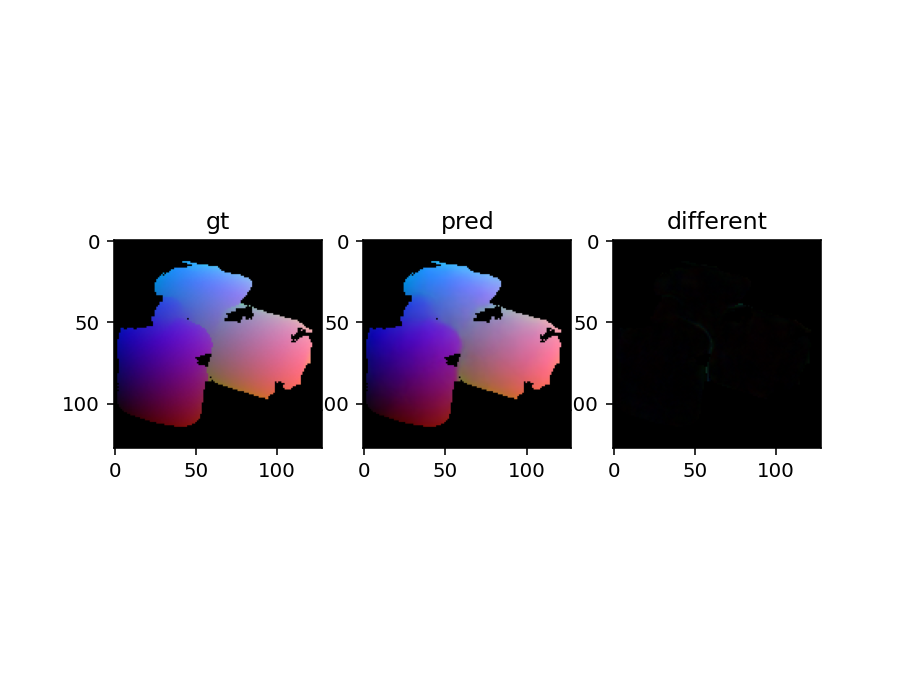

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [109]:


plt.figure()
ax1 = plt.subplot(131)
ax1.set_title('gt')
plt.imshow(masked_xyz_gt, vmin=masked_xyz_gt.min(), vmax=masked_xyz_gt.max())
ax2 = plt.subplot(132)
ax2.set_title('pred')
plt.imshow(masked_xyz, vmin=masked_xyz.min(), vmax=masked_xyz.max())
ax3 = plt.subplot(133)
ax3.set_title('different')
plt.imshow(masked_xyz_res, vmin=masked_xyz_res.min(), vmax=masked_xyz_res.max())
plt.show()

xyz_choosed = masked_xyz.reshape(-1, 3)[_choose[0][0]]
xyz_gt_choosed = masked_xyz_gt.reshape(-1, 3)[_choose[0][0]]

### 1.2 查看重建模型

### 1.2.1 coordinate

<IPython.core.display.Javascript object>


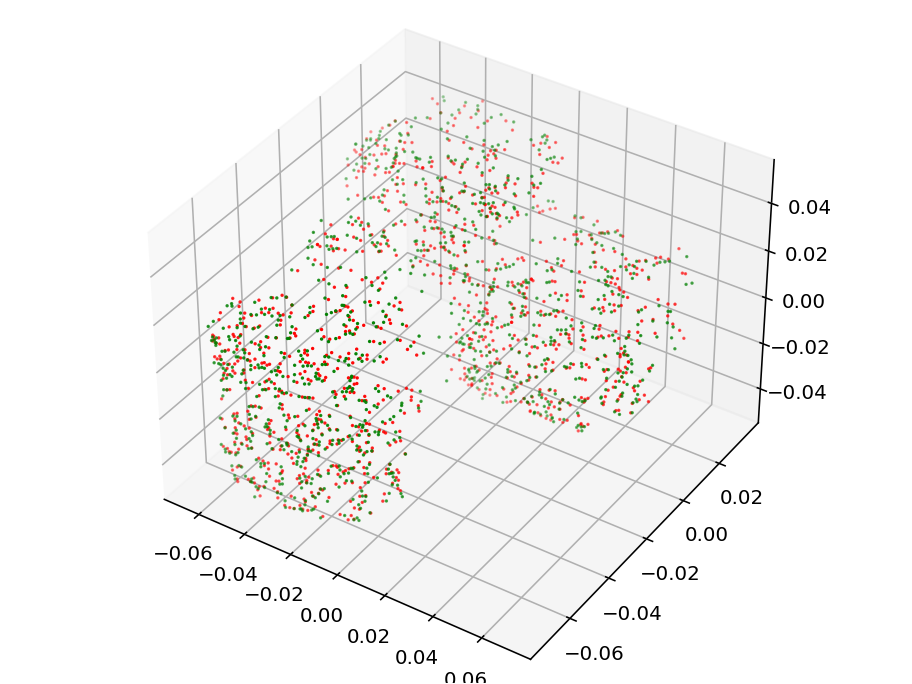

In [110]:
fig = plt.figure()
ax = Axes3D(fig,  auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(coordinate_choose_gt[:, 0], coordinate_choose_gt[:, 1], coordinate_choose_gt[:, 2], c='r', s=0.5)
ax.scatter(coordinate_choosed[:, 0], coordinate_choosed[:, 1], coordinate_choosed[:, 2], c='g', s=0.5)
plt.show()

### 1.2.2 xyz

<IPython.core.display.Javascript object>


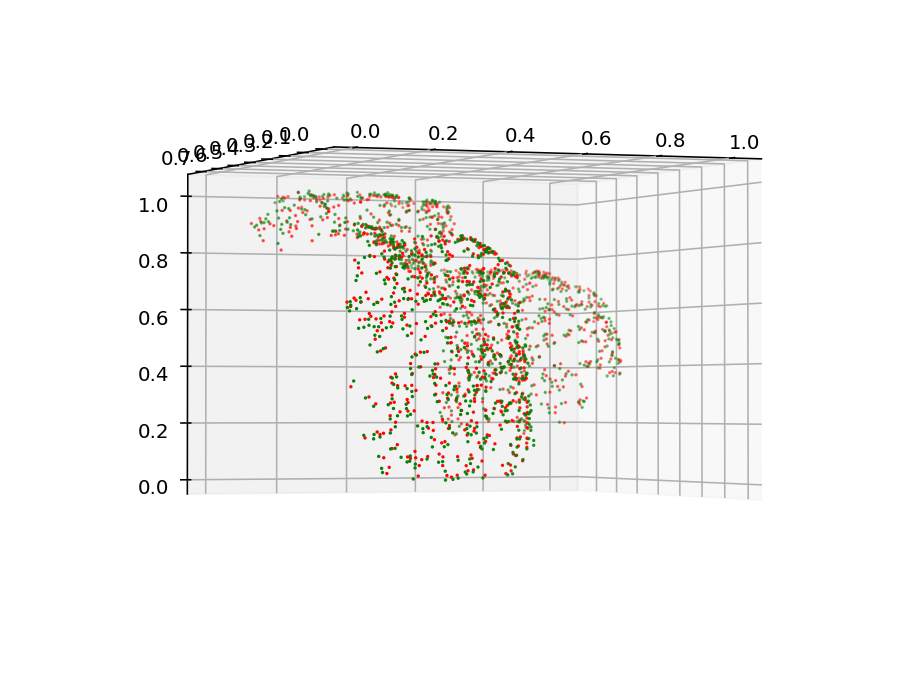

In [111]:
fig = plt.figure()
ax = Axes3D(fig,  auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(xyz_gt_choosed[:, 0], xyz_gt_choosed[:, 1], xyz_gt_choosed[:, 2], c='r', s=0.5)
ax.scatter(xyz_choosed[:, 0], xyz_choosed[:, 1], xyz_choosed[:, 2], c='g', s=0.5)
plt.show()

### 1.3 对mask的预测

<IPython.core.display.Javascript object>


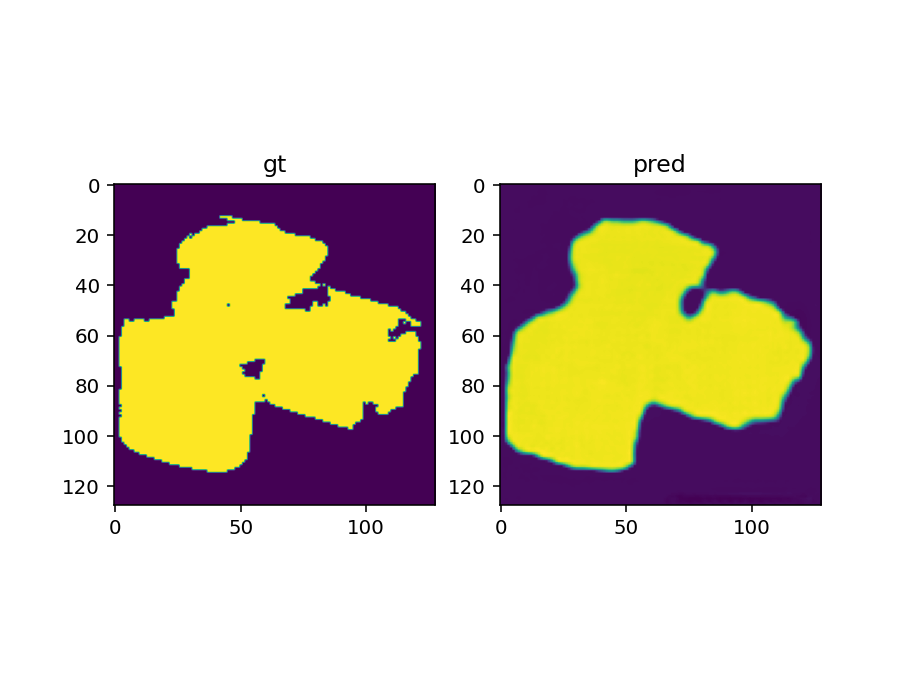

In [112]:
plt.figure()
ax1 = plt.subplot(121)
plt.imshow(mask_gt[0])
ax1.set_title('gt')
ax2 = plt.subplot(122)
plt.imshow(mask[0])
ax2.set_title('pred')
plt.show()

### 1.4 对region的预测

<IPython.core.display.Javascript object>


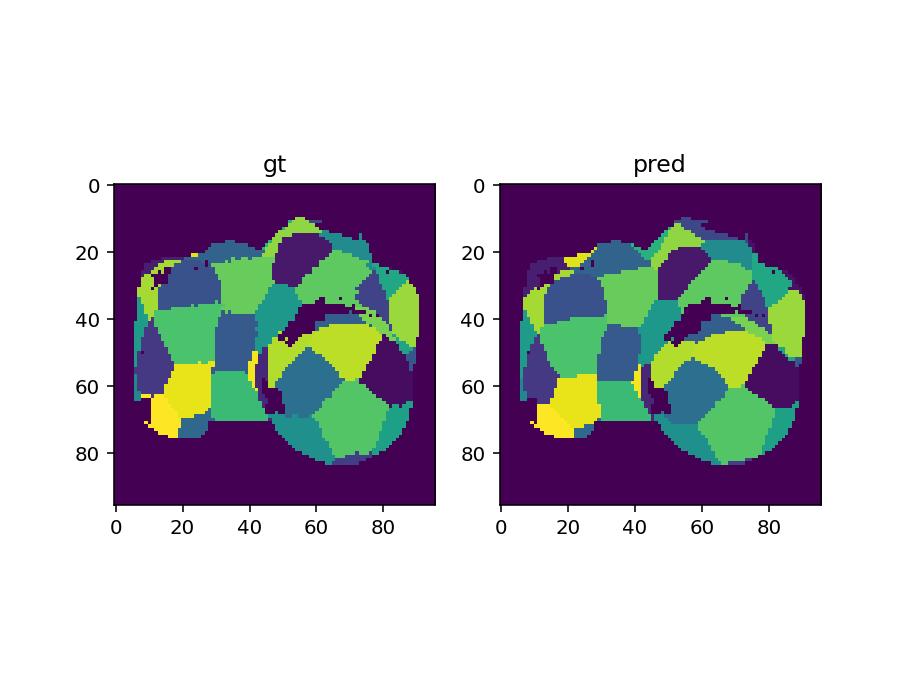

In [28]:
region_pred_map = torch.argmax(region_pred, 0)
plt.figure()
ax1 = plt.subplot(121)
plt.imshow(region_gt)
ax1.set_title('gt')
ax2 = plt.subplot(122)
plt.imshow(region_pred_map)
ax2.set_title('pred')
plt.show()

### 1.5 depth

In [29]:
target.shape

torch.Size([2600, 3])

<IPython.core.display.Javascript object>


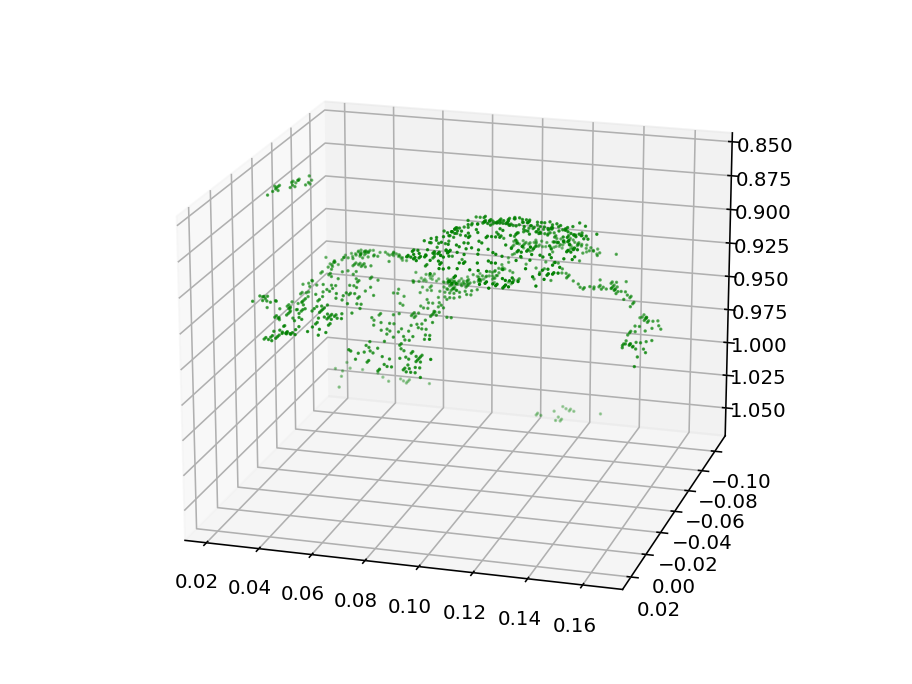

In [30]:
fig = plt.figure()
ax = Axes3D(fig,  auto_add_to_figure=False)
fig.add_axes(ax)
# ax.scatter(target[..., 0], target[..., 1], target[..., 2], c='r', s=0.5)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='g', s=0.5)
plt.show()

### 1.6 choose

In [31]:
mv, mu = torch.where(mask_gt[0])
mlv, mlu = torch.where(mask_label[0])
mov, mou = torch.where(mask_obj[0])
mdv, mdu = torch.where(mask_depth[0])

h = mask_gt.shape[1]

cu = _choose % h
cv = _choose / h

NameError: name 'mask_label' is not defined

<IPython.core.display.Javascript object>


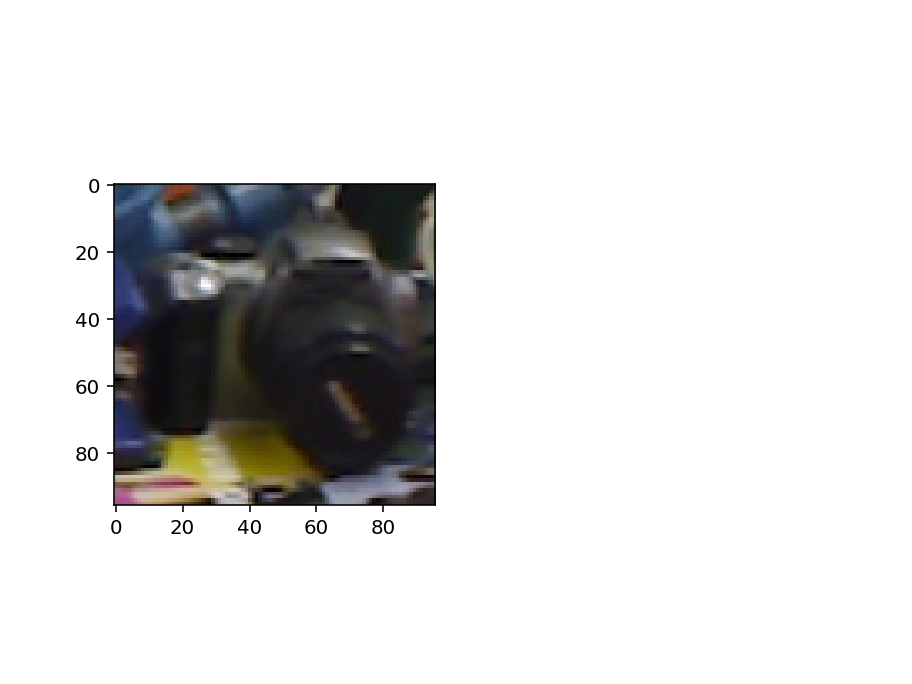

NameError: name 'cu' is not defined

In [32]:
plt.figure()
plt.subplot(121)
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(cu, cv, s=1.0)
plt.subplot(122)
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(mu, mv, s=1.0)
plt.show()

In [ ]:
plt.figure()

ax1 = plt.subplot(221)
ax1.set_title('mask')
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(mu, mv, s=1.0)

ax2 = plt.subplot(222)
ax2.set_title('mask_label')
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(mlu, mlv, s=1.0)

ax3 = plt.subplot(223)
ax3.set_title('mask_obj')
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(mou, mov, s=1.0)

ax4 = plt.subplot(224)
ax4.set_title('mask_depth')
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(mdu, mdv, s=1.0)

plt.show()

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(ori_img[rmin:rmax, cmin:cmax, :])
plt.scatter(cu, cv, s=1.0)
plt.subplot(122)
plt.imshow(depth[0], vmin=depth.min(), vmax=depth.max())
plt.show()